In [15]:
# Suppress TensorFlow INFO and WARNING messages
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Standard Library Imports
import importlib
from glob import glob
import warnings
from typing import List
import time

# External Library Imports
import yaml
import numpy as np
from patoolib import extract_archive
from matplotlib import pyplot as plt
from matplotlib import cm

# Local Module Imports
import utils

importlib.reload(utils)
from utils import wkt2masc, load_images_from_folder, frame_to_label, save_history, label_to_frame

import polygon_handle

importlib.reload(polygon_handle)
from polygon_handle import masks_to_polygons

import visualization

# reload the module
importlib.reload(visualization)
from visualization import plot_learning_curves

In [10]:
current_dir = os.getcwd()
BASE_DIR = os.path.dirname(current_dir)
dataset_dir = os.path.join(BASE_DIR, "dataset")
data_dir = os.path.join(BASE_DIR, "data")
config_file = os.path.join(BASE_DIR, "config.yml")

DATA = "sampled"  # "full" or "sampled"
MODE = "extrapol"  # "interpol" or "extrapol"

In [6]:
# if there isn´t unrar installed, install it with: sudo apt-get install unrar (linux)
# for windows, install it from: https://www.rarlab.com/rar_add.htm (unrarw32.exe)

dataset_path = os.path.join(dataset_dir, "BurnedAreaUAV_dataset")
if not os.path.exists(dataset_path):
    extract_archive(
        os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"),
        program="unrar",
        outdir=dataset_dir,
    )
    os.remove(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"))

with open(config_file, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

### Masks directories creation and conversion

In [8]:
dataset_train_msks_path = os.path.join(dataset_path, "PNG", "train", "msks")
dataset_test_msks_path = os.path.join(dataset_path, "PNG", "test", "msks")
train_msks_list = [
    os.path.basename(x) for x in glob(dataset_train_msks_path + "/*.png")
]
test_msks_list = [os.path.basename(x) for x in glob(dataset_test_msks_path + "/*.png")]

# Iterate over the 'interpol' and 'extrapol' keys
for key in ["interpol", "extrapol"]:
    for sub_key in ["full", "sampled"]:
        for sub_sub_key in ["PNG", "WKT"]:
            # Create the directories
            dir_path = os.path.join(BASE_DIR, "outputs/CVAE", key, sub_key, sub_sub_key)
            os.makedirs(dir_path, exist_ok=True)
            # Create a .gitkeep file in the directory
            with open(os.path.join(dir_path, ".gitkeep"), "w") as f:
                pass

train_masks_dir = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
if not os.path.exists(train_masks_dir):
    os.makedirs(train_masks_dir)

test_masks_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
if not os.path.exists(test_masks_dir):
    os.makedirs(test_masks_dir)

sampled_masks_txt_path = os.path.join(BASE_DIR, config["data"]["sampled_masks_txt"])
with open(sampled_masks_txt_path, "r", encoding="utf-8") as f:
    polygons = f.readlines()
    # extract indexes
    indexes = [int(polygon.split(",")[0]) for polygon in polygons]

train_sampled_masks_dir = os.path.join(
    BASE_DIR, config["data"]["train_sampled_dir"], "masks"
)
if not os.path.exists(train_sampled_masks_dir):
    os.makedirs(train_sampled_masks_dir)

### Convert WKT files to segmentation masks : full train, sampled train and test

In [4]:
wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["train_wkt"]),
    images_path=train_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["test_wkt"]),
    images_path=test_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["sampled_masks_wkt"]),
    images_path=train_sampled_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)


    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 226
    --------------------------------------
    


  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 226/226 [00:00<00:00, 606.18it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 23
    --------------------------------------
    


100%|██████████| 23/23 [00:00<00:00, 639.11it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 13
    --------------------------------------
    


100%|██████████| 13/13 [00:00<00:00, 674.56it/s]


In [9]:
# reconstruct the masks labels
msks_train_paths = sorted(glob(os.path.join(train_masks_dir, "*.png")))
msks_train_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 for m in msks_train_paths]
msks_test_paths = sorted(glob(os.path.join(test_masks_dir, "*.png")))
msks_test_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 + 20250 for m in msks_test_paths]
msks_train_sampled_paths = sorted(glob(os.path.join(train_sampled_masks_dir, "*.png")))
msks_train_sampled_labels = [100 * i for i in indexes]

print("Train masks:", len(msks_train_paths))
print("Train sampled masks:", len(msks_train_sampled_paths))
print("Test masks:", len(msks_test_paths))

Train masks: 226
Train sampled masks: 13
Test masks: 23


### Load masks and process labels

In [33]:
if DATA == "full":
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
    train_masks = load_images_from_folder(
        TRAIN_DIR, target_size=config["data"]["input_size"][:2]
    )
    # labels normalization and reshaping
    max_val = np.max(msks_train_labels)
    train_labels = (msks_train_labels / max_val).astype(np.float32)
    train_labels = np.expand_dims(train_labels, axis=-1)
else:
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
    train_masks = load_images_from_folder(
        TRAIN_DIR, target_size=config["data"]["input_size"][:2]
    )
    # labels normalization and reshaping
    max_val = np.max(msks_train_labels)
    train_labels = (msks_train_sampled_labels / max_val).astype(np.float32)
    train_labels = np.expand_dims(train_labels, axis=-1)

if MODE == "extrapol":  # truncate the train set to aprox. 80% of the original size
    train_masks = train_masks[: int(0.8 * len(train_masks))]
    train_labels = train_labels[: int(0.8 * len(train_labels))]
    # print each label number with label_to_frame
    print("\nTruncated training labels:", end=' ')
    for i in range(len(train_labels)):
        print(label_to_frame(train_labels[i], max_val), end=', ')
    print(f"| Total No. of labels: {len(train_labels)}\n")


TEST_DIR = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
test_masks = load_images_from_folder(
    TEST_DIR, target_size=config["data"]["input_size"][:2]
)
test_labels = (msks_test_labels / max_val).astype(np.float32)
test_labels = np.expand_dims(test_labels, axis=-1)

print("-" * 58)
print(f"{'Variable':<15} {'Shape (N,H,W,C)':<18} {'Dtype':<9} {'Max':<7} {'Min':<8}")
print("-" * 58)
print(
    f"{'train_imgs':<15} {str(train_masks.shape):<18} {str(train_masks.dtype):<8}  {np.max(train_masks):.1f}    {np.min(train_masks):.1f}"
)
print(
    f"{'train_labels':<15} {str(train_labels.shape):<18} {str(train_labels.dtype):<8}  {np.max(train_labels):.1f}     {np.min(train_labels):.1f}"
)
print("~" * 58)
print(
    f"{'test_imgs':<15} {str(test_masks.shape):<18} {str(test_masks.dtype):<8}  {np.max(test_masks):.1f}    {np.min(test_masks):.1f}"
)
print(
    f"{'test_labels':<15} {str(test_labels.shape):<18} {str(test_labels.dtype):<8}  {np.max(test_labels):.1f}     {np.min(test_labels):.1f}"
)
print("-" * 58)


Truncated training labels: 0, 1899, 2800, 4800, 5600, 7400, 8200, 8700, 10600, 12800, | Total No. of labels: 10

----------------------------------------------------------
Variable        Shape (N,H,W,C)    Dtype     Max     Min     
----------------------------------------------------------
train_imgs      (10, 512, 512, 1)  float32   1.0    -1.0
train_labels    (10, 1)            float32   0.6     0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
test_imgs       (23, 512, 512, 1)  float32   1.0    -1.0
test_labels     (23, 1)            float32   1.0     0.9
----------------------------------------------------------


### Model

In [34]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, Lambda, Input, Dense
from tensorflow.keras.layers import MaxPooling2D, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-12-29 18:17:34.750594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 18:17:34.750620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 18:17:34.751402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [35]:
def deconv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
          input (tensor): Input tensor to the block.
          filters (int): Number of filters in the convolutional layers.

    Returns:
          tensor: Output tensor of the block with ReLU activation.
    """
    x = Conv2DTranspose(
        filters,
        kernel_size=(4, 4),
        strides=2,
        kernel_initializer=f_init,
        data_format="channels_last",
        padding="same",
    )(input)

    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(x)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(x)
    activation = Activation(tf.nn.leaky_relu)(x)

    return activation

In [36]:
def conv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(input)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(x)
    ativ = Activation(tf.nn.leaky_relu)(x)

    m_pool = MaxPooling2D(
        pool_size=(2, 2), strides=2, data_format="channels_last", padding="same"
    )(ativ)

    return m_pool

In [37]:
def sampler(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [38]:
H, W, C = config["data"]["input_size"]

# --------
# Encoder
# --------

encoder_inputs = Input(shape=(H, W, C))
# Reshape input to 2D image

x = conv_block(
    encoder_inputs, config["CVAE"]["ref_filters"] * 2, config["CVAE"]["w_init"]
)
x = conv_block(x, config["CVAE"]["ref_filters"] * 1, config["CVAE"]["w_init"])
x = Flatten()(x)
x = Dense(64, activation="leaky_relu")(x)

# VAE specific layers for mean and log variance
z_mean = Dense(config["CVAE"]["latent_dim"], activation="leaky_relu", name="z_mean")(x)
z_log_var = Dense(
    config["CVAE"]["latent_dim"], activation="leaky_relu", name="z_log_var"
)(x)

# Sampling layer to sample z from the latent space
z = Lambda(sampler, output_shape=(config["CVAE"]["latent_dim"],), name="z")(
    [z_mean, z_log_var]
)

# Instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --------
# Decoder
# --------

latent_inputs = Input(shape=(config["CVAE"]["latent_dim"],), name="z_sampling")
label_size = len(train_labels[0])
label_inputs = Input(shape=(label_size,), name="label")
decoder_inputs = Concatenate()([latent_inputs, label_inputs])
x = Dense(64 * 64 * 64, activation="leaky_relu")(decoder_inputs)
x = Reshape((128, 128, 16))(x)
x = deconv_block(x, config["CVAE"]["ref_filters"] * 2, config["CVAE"]["w_init"])
x = deconv_block(x, config["CVAE"]["ref_filters"] * 4, config["CVAE"]["w_init"])
decoder_output = Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)

decoder = Model([latent_inputs, label_inputs], decoder_output, name="decoder")

# -----------------
# Conditional VAE
# -----------------

outputs = decoder([encoder(encoder_inputs)[2], label_inputs])
cvae = Model([encoder_inputs, label_inputs], outputs, name="cvae")
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 3357281   ['input_1[0][0]']             
                              (None, 64),                 6                                       
                              (None, 64)]                                                         
                                                                                                  
 label (InputLayer)          [(None, 1)]                  0         []                            
                                                                                               

In [39]:
def mse_kl_loss(y_true, y_pred, beta: float = 1.0):
    """Calculate loss = reconstruction loss + KL loss for each data in minibatch"""
    # E[log P(X|z)]
    squared_difference = tf.square(y_true - y_pred)
    reconstruction = tf.reduce_mean(squared_difference, axis=-1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl_divergence = 0.5 * tf.reduce_sum(
        tf.exp(z_log_var) + tf.square(z_mean) - 1.0 - z_log_var, axis=-1
    )
    return reconstruction + beta * kl_divergence

In [40]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, mode="min", patience=30, verbose=1, min_lr=1e-8
)

checkpoint_dir = os.path.join(BASE_DIR, config["data"]["checkpoint_dir"])
checkpoint_filepath = os.path.join(checkpoint_dir, f"cvae_{DATA}_{MODE}.h5")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    mode="auto",
    verbose=1,
    monitor="loss",
)

In [41]:
cvae.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-4), loss=mse_kl_loss
)

In [42]:
history = cvae.fit(
    [train_masks, train_labels],
    train_masks,
    epochs=config["CVAE"]["epochs"],
    batch_size=1,
    validation_data=([test_masks, test_labels], test_masks),
    callbacks=[reduce_lr, checkpoint],
)

Train on 10 samples, validate on 23 samples
Epoch 1/500


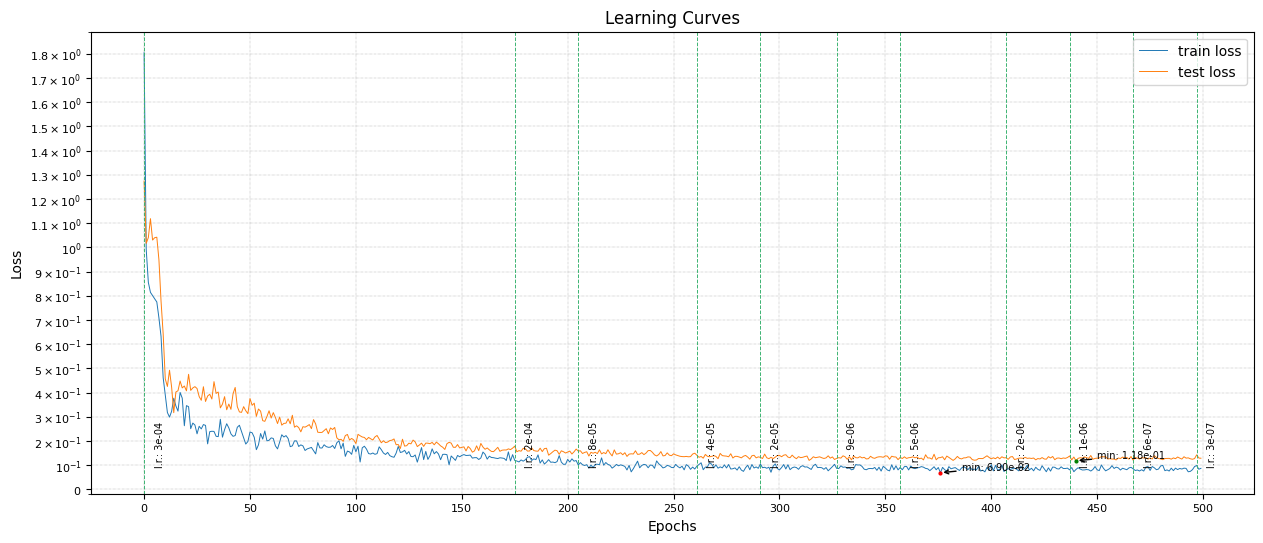

In [20]:
plot_learning_curves(history, log_scale=True)
save_history(history, os.path.join(checkpoint_dir, f"history_{DATA}_{MODE}.log"))

In [21]:
# load the best model
cvae.load_weights(checkpoint_filepath)

## Inference

In [1]:
import cv2


def generate_frames(
    decoder, output_dir: str, total_frames: int = 22500, resize_original: bool = False
):
    """
    Generates and saves the frames from a trained decoder.

    Parameters:
        decoder (keras.Model): The trained decoder.
        output_dir (str): The path to the output directory.
        total_frames (int): The total number of frames to generate.
        resize_original (bool): Whether to resize the frames to the original dimensions.
    """

    start_total_time = time.time()

    frames_num = np.arange(1, total_frames + 1, 1)

    for i in range(total_frames):
        frame_num = frames_num[i]

        # Sample from the latent space
        z_sample = np.full((1, config["CVAE"]["latent_dim"]), 0.5)

        # Generate the frame
        try:
            start_time = time.time()
            reconst = decoder.predict([z_sample, frame_to_label(frame_num)])
            reconst_time = (time.time() - start_time) * 1000
            reconst = np.squeeze(reconst, axis=0)
        except Exception as e:
            print(f"Error generating frame {frame_num}: {e}")
            continue

        if resize_original:
            start_time = time.time()
            reconst = tf.image.resize(
                images=reconst, size=config["data"]["original_vid_dims"]
            )
            resize_time = (time.time() - start_time) * 1000
        else:
            resize_time = 0.0  # Not resizing

        # Binarize the reconstructed image with OpenCV
        start_time = time.time()
        _, thresh_img = cv2.threshold(
            reconst, config["CVAE"]["threshold"], 255, cv2.THRESH_BINARY
        )
        threshold_time = (time.time() - start_time) * 1000

        # Save the thresholded image as png in grayscale
        try:
            start_time = time.time()
            cv2.imwrite(
                os.path.join(output_dir, f"frame_{frame_num:06d}.png"), thresh_img
            )
            save_time = (time.time() - start_time) * 1000
        except Exception as e:
            print(f"Error saving frame {frame_num}: {e}")
            continue

        # Print progress with time information
        print(
            f"Generated frame {i+1} of {total_frames} | "
            f"Reconst: {reconst_time:.2f}ms | "
            f"Resize: {resize_time:.2f}ms | "
            f"Threshold: {threshold_time:.2f}ms | "
            f"Save: {save_time:.2f}ms | "
            f"Elapsed Time: {time.time() - start_total_time:.2f}s  ",
            end="\r",
        )
    print()

In [23]:
output_png_dir = os.path.join(BASE_DIR, 'outputs', 'CVAE', MODE, DATA, 'PNG')
# generate and save the frames in PNG format
generate_frames(decoder, output_png_dir)

/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Generated frame 22500 of 22500 | Reconst: 26.13ms | Resize: 0.00ms | Threshold: 0.10ms | Save: 0.58ms | Elapsed Time: 554.43s  


In [47]:
# List of generated frames paths
msks_paths = sorted(glob(os.path.join(output_png_dir, "*.png")))

# Convert the masks to polygons and save them as a WKT file
polygons = masks_to_polygons(
    msks_paths,
    out_dim=tuple(config["data"]["original_vid_dims"]),
    save_path=os.path.join(BASE_DIR, config["outputs"][MODE][DATA] + "/WKT"),
)